# Footprinting / expr correlations

## Load libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\boldmath \usepackage{amsmath} \usepackage{amssymb}'
from matplotlib.pyplot import cm

from adjustText import adjust_text

import scipy

import itertools
from collections import Counter

from scipy.stats.stats import pearsonr, spearmanr

import gc

In [2]:
def ztransform(arr):
    
    arr_zvals = (arr.T - arr.mean(axis=1))/arr.std(axis=1)
    arr_zvals = arr_zvals.T
    
    return arr_zvals

## Load data

In [3]:
data_dir = '/home/andrew/biology/xdf/rotation3/mammalian_eftfs/data/tobias/bindetect_results'

## differential binding data ##
tobias_bindetect_file = 'bindetect_results_full_timecourse.txt'
tobias_bindetect_ef_file = 'bindetect_results_full_timecourse_EFup.txt'

## peak context annotations ##
atac_data_dir = '../data'
atac_file = 'ATACseq-CQN-preprocessed-norm-counts.tsv' 

## TOBIAS footprint scores (sum for each peak) ##
tobias_score_dir = '/home/andrew/biology/xdf/rotation3/mammalian_eftfs/data/tobias/footprint_score_files'
d0_score_file = 'tobias_timecourse_D0_footprint_scores.csv'
d1_score_file = 'tobias_timecourse_D1_footprint_scores.csv'
d2_score_file = 'tobias_timecourse_D2_footprint_scores.csv'
d3_score_file = 'tobias_timecourse_D3_footprint_scores.csv'
d5_score_file = 'tobias_timecourse_D5_GFPplus_footprint_scores.csv'


# rna-seq files #
rna_data_dir = '../data'
rna_file = 'RNAseq-DEseq2-preprocessed-norm-counts.tsv'

#
tf_database_file = '/home/andrew/biology/xdf/projects/utils/TF_lists/Mus_musculus_TF.txt'

## Load ATAC data

In [4]:
# -- load atac peak counts -- #
atac_df = pd.read_csv(atac_data_dir+'/'+atac_file, sep='\t')
print(atac_df.shape)

# add peak width as features
atac_df['peak-width'] = atac_df['chromEnd'] - atac_df['chromStart']

print(atac_df.shape)
print(atac_df.columns)

atac_df['chromEnd']   = atac_df['chromEnd'].astype(int)
atac_df['chromStart'] = atac_df['chromStart'].astype(int)

(361867, 14)
(361867, 15)
Index(['Unnamed: 0', 'D0', 'D1', 'D2', 'D3', 'D5_GFPminus', 'D5_GFPplus',
       'chrom', 'chromStart', 'chromEnd', 'context', 'nearest_gene_ensemble',
       'nearest_gene_id', 'tad-id-bonev', 'peak-width'],
      dtype='object')


## Load rna-seq data

In [5]:
## ---------------------  ##
## -- load RNAseq data -- ##
## ---------------------- ##
rna_df = pd.read_csv(rna_data_dir+'/'+rna_file, sep='\t')

rna_df['day0'] = rna_df[['Day0_1','Day0_2','Day0_3']].mean(axis=1)
rna_df['day1'] = rna_df[['Day1_1','Day1_2','Day1_3']].mean(axis=1)
rna_df['day2'] = rna_df[['Day2_1','Day2_2','Day2_3']].mean(axis=1)
rna_df['day3'] = rna_df[['Day3_1','Day3_2','Day3_3']].mean(axis=1)
rna_df['day4-gfpneg'] = rna_df[['Day4_GFPneg_1','Day4_GFPneg_2','Day4_GFPneg_3']].mean(axis=1)
rna_df['day4-gfppos'] = rna_df[['Day4_GFPpos_1','Day4_GFPpos_2','Day4_GFPpos_3']].mean(axis=1)
rna_df['day5-gfpneg'] = rna_df[['Day5_GFPneg_1','Day5_GFPneg_2','Day5_GFPneg_3']].mean(axis=1)
rna_df['day5-gfppos'] = rna_df[['Day5_GFPpos_1','Day5_GFPpos_2','Day5_GFPpos_3']].mean(axis=1)

print(rna_df.columns, rna_df.shape)

Index(['Unnamed: 0', 'ext_gene', 'ens_gene', 'chrom', 'chromStart', 'chromEnd',
       'strand', 'Day0_1', 'Day0_2', 'Day0_3', 'Day1_1', 'Day1_2', 'Day1_3',
       'Day2_1', 'Day2_2', 'Day2_3', 'Day3_1', 'Day3_2', 'Day3_3',
       'Day4_GFPneg_1', 'Day4_GFPneg_2', 'Day4_GFPneg_3', 'Day4_GFPpos_1',
       'Day4_GFPpos_2', 'Day4_GFPpos_3', 'Day5_GFPneg_1', 'Day5_GFPneg_2',
       'Day5_GFPneg_3', 'Day5_GFPpos_1', 'Day5_GFPpos_2', 'Day5_GFPpos_3',
       'EF-up', 'EF-down', 'D0-D1-up', 'D0-D1-down', 'D1-D2-up', 'D1-D2-down',
       'D2-D3-up', 'D2-D3-down', 'HK', 'tad-id-bonev', 'day0', 'day1', 'day2',
       'day3', 'day4-gfpneg', 'day4-gfppos', 'day5-gfpneg', 'day5-gfppos'],
      dtype='object') (49705, 49)


In [6]:
## load Mus musculus TF list
tf_list_df = pd.read_csv(tf_database_file,sep='\t')
tf_list = tf_list_df['Symbol'].tolist()
print(len(tf_list))

ef_up_tfs   = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['EF-up']].tolist()
ef_down_tfs = rna_df['ext_gene'][rna_df['ext_gene'].isin(tf_list) & rna_df['EF-down']].tolist()

## number of up and down-regulated genes that are TFs ##
print('EF up TFs:  ', len(ef_up_tfs), 'of', rna_df['EF-up'].sum())
print('EF down TFs:', len(ef_down_tfs), 'of', rna_df['EF-down'].sum())

1636
EF up TFs:   11 of 37
EF down TFs: 65 of 453


## Load tobias bindetect data

In [7]:
bindetect_results          = pd.read_csv(data_dir+'/'+tobias_bindetect_file,sep='\t')
bindetect_results_ef       = pd.read_csv(data_dir+'/'+tobias_bindetect_ef_file,sep='\t')

In [8]:
motifs          = bindetect_results['output_prefix']
motifs_ef       = bindetect_results_ef['output_prefix']
print(len(motifs), len(motifs_ef))

606 606


## Load TOBIAS scores and take means

In [9]:
## up-regulated eye-field genes ##
ef_up_tad_numbers = sorted(list(set(rna_df['tad-id-bonev'][rna_df['EF-up']])))
ef_up_tad_numbers = list(filter(lambda a: a != -1, ef_up_tad_numbers))
print(len(ef_up_tad_numbers))

bool_EFup_peaks   = atac_df['tad-id-bonev'].isin(ef_up_tad_numbers) & (atac_df['context'] != 'exon')
print(bool_EFup_peaks.sum())

28
4339


**Note:** in order to perform this anaylsis (as you have done genome-wide and for EFup TADs, you need to have the information on how many instances of each motif are found in these sets of peaks separately. 

In [10]:
## ---------------------- ##
## -- load tobias data -- ##
## ---------------------- ##

def get_tobias_scores(scores_file, bindetect_df, bindetect_select_df, bool_peaks):
    
    ## 0. load tobias footprint scores
    tobias_scores = pd.read_csv(scores_file)
    tobias_scores = tobias_scores.drop(columns=['Unnamed: 0','peak-id'])
    
    ## 1. sum footprint scores across peaks
    genome_wide_scores_df = tobias_scores.sum(axis=0)
    selection_scores_df = tobias_scores[bool_peaks].sum(axis=0)
    
    ## 2. now obtain total number of motif occurences in these peaks
    bindetect_motifs = bindetect_df['output_prefix'].tolist()
    bindetect_select_motifs = bindetect_select_df['output_prefix'].tolist()
    tobias_motifs = tobias_scores.columns.tolist()

    nmotif_occurences_gw     = []
    nmotif_occurences_select = []
    for motif in tobias_motifs:

        nmotif_occurences_gw.append(bindetect_df['total_tfbs'].iloc[bindetect_motifs.index(motif)])
        nmotif_occurences_select.append(bindetect_select_df['total_tfbs'].iloc[bindetect_select_motifs.index(motif)])

    nmotif_occurences_gw     = np.array(nmotif_occurences_gw)
    nmotif_occurences_select = np.array(nmotif_occurences_select)
    
    ## 3. divide total motif footprint score by number of motif occurences
    genome_wide_scores_df /= nmotif_occurences_gw
    selection_scores_df /= nmotif_occurences_select
    
    del tobias_scores
    gc.collect()
    
    return genome_wide_scores_df, selection_scores_df

In [11]:
d0_scores_gw, d0_scores_EFup = get_tobias_scores(tobias_score_dir+'/'+d0_score_file,
                                                 bindetect_results, bindetect_results_ef, bool_EFup_peaks)
print('day0 shapes:', d0_scores_gw.shape, d0_scores_EFup.shape)
d1_scores_gw, d1_scores_EFup = get_tobias_scores(tobias_score_dir+'/'+d1_score_file,
                                                 bindetect_results, bindetect_results_ef, bool_EFup_peaks)
print('day1 shapes:', d1_scores_gw.shape, d1_scores_EFup.shape)
d2_scores_gw, d2_scores_EFup = get_tobias_scores(tobias_score_dir+'/'+d2_score_file,
                                                 bindetect_results, bindetect_results_ef, bool_EFup_peaks)
print('day2 shapes:', d2_scores_gw.shape, d2_scores_EFup.shape)
d3_scores_gw, d3_scores_EFup = get_tobias_scores(tobias_score_dir+'/'+d3_score_file,
                                                 bindetect_results, bindetect_results_ef, bool_EFup_peaks)
print('day3 shapes:', d3_scores_gw.shape, d3_scores_EFup.shape)
d5_scores_gw, d5_scores_EFup = get_tobias_scores(tobias_score_dir+'/'+d5_score_file,
                                                 bindetect_results, bindetect_results_ef, bool_EFup_peaks)
print('day5 shapes:', d5_scores_gw.shape, d5_scores_EFup.shape)

day0 shapes: (606,) (606,)
day1 shapes: (606,) (606,)
day2 shapes: (606,) (606,)
day3 shapes: (606,) (606,)
day5 shapes: (606,) (606,)


In [12]:
mean_footprint_gw_arr = np.vstack((d0_scores_gw, d1_scores_gw, d2_scores_gw, 
                                   d3_scores_gw, d5_scores_gw))
mean_footprint_gw_df = pd.DataFrame(mean_footprint_gw_arr,columns=d0_scores_gw.index.tolist())


mean_footprint_EFup_arr = np.vstack((d0_scores_EFup, d1_scores_EFup, d2_scores_EFup, 
                                     d3_scores_EFup, d5_scores_EFup))
mean_footprint_EFup_df = pd.DataFrame(mean_footprint_EFup_arr,columns=d0_scores_EFup.index.tolist())
print(mean_footprint_gw_df.shape, mean_footprint_EFup_df.shape)

(5, 606) (5, 606)


## List of expressed motifs

In [13]:
###################################################################
### generate list of motifs in motif database and are expressed ###
###################################################################

rna_thr = 50 ## DEseq2 RNAseq normalization

motif_names = list(bindetect_results['name'].tolist())
motif_names_format = [motif.split('_')[0].capitalize() for motif in motif_names]
motif_names_format = [motif.split('(')[0] for motif in motif_names_format]

motif_w_rna_signal = rna_df['ext_gene'][rna_df['ext_gene'].isin(motif_names_format)].tolist()
motif_w_rna_signal = list(set(motif_w_rna_signal))
rna_days_test = ['day1','day2','day3','day4-gfppos','day5-gfppos']

jasper_names = list(bindetect_results['output_prefix'].tolist())
expressed_motifs = []
expressed_motifs_names = []
for motif in motif_w_rna_signal:
    
    tmp_rna_max_signal = rna_df[rna_days_test][rna_df['ext_gene'] == motif].values.max()
    
    if tmp_rna_max_signal > rna_thr:
        
        tmp_list = list(np.array(jasper_names)[np.where(np.array(motif_names_format)==motif)[0]])
        expressed_motifs.append(tmp_list) ## there can be > 1 motif per TF
        expressed_motifs_names.append([motif]*len(tmp_list))

expressed_motifs = [item for sublist in expressed_motifs for item in sublist]
expressed_motifs_names = [item for sublist in expressed_motifs_names for item in sublist]

# (remove duplicate)
tmp_idx = expressed_motifs.index('Six3_PH0163.1')
expressed_motifs.remove('Six3_PH0163.1')
print(expressed_motifs_names[tmp_idx])
expressed_motifs_names.pop(tmp_idx)

print(len(expressed_motifs), len(expressed_motifs_names))

Six3
353 353


## TF expression vs TF footprinting -- genome-wide and EFup

In [14]:
tobias_fp_days = ['D0_footprints_mean_score','D1_footprints_mean_score',
                  'D2_footprints_mean_score', 'D3_footprints_mean_score',
                  'D5_GFPplus_footprints_mean_score']

## expressed motifs names ##

expressed_motifs_ids = expressed_motifs

## genome-wide scores ##
motif_footprint_scores = mean_footprint_gw_df[expressed_motifs_ids].values.T
print(motif_footprint_scores.shape)

## EF TAD scores ##
motif_footprint_scores_ef = mean_footprint_EFup_df[expressed_motifs_ids].values.T
print(motif_footprint_scores_ef.shape)

## z-transform footprint scores
motif_footprint_zvals = ztransform(motif_footprint_scores)
print(motif_footprint_zvals.shape)

motif_footprint_ef_zvals = ztransform(motif_footprint_scores_ef)
print(motif_footprint_ef_zvals.shape)

(353, 5)
(353, 5)
(353, 5)
(353, 5)


In [15]:
## heatmap of TF expression vs TF footprinting
tf_expr_arr = []
for motif in expressed_motifs_ids:
    
    gene_name = expressed_motifs_names[expressed_motifs.index(motif)]
    gene_expr = rna_df[rna_days_test][rna_df['ext_gene']==gene_name].values[0]
    gene_expr = np.log2(gene_expr + 1)
    tf_expr_arr.append(list(gene_expr))
    #print()
    #print(motif, gene_id)
tf_expr_arr = np.array(tf_expr_arr)
print(tf_expr_arr.shape)

tf_expr_zvals = ztransform(tf_expr_arr)
print(tf_expr_zvals.shape)

(353, 5)
(353, 5)


In [16]:
de_genes = rna_df['ext_gene'][rna_df['EF-up'] | rna_df['EF-down']].tolist()
de_genes.append('Sox2')
de_genes.append('Otx2')

print([gene for gene in de_genes if gene in expressed_motifs_names])
print(len([gene for gene in de_genes if gene in expressed_motifs_names]))

expr_footprint_lag = []
expr_footprint_best_corr = []
expr_footprint_ef_lag = []
expr_footprint_ef_best_corr = []
de_tf_expr_arr = []
de_motif_footprint_arr = []
de_motif_footprint_ef_arr = []
motif_names = []
gene_names = []

for k, motif in enumerate(expressed_motifs_ids):
    
    gene_name = expressed_motifs_names[expressed_motifs.index(motif)]
    gene_expr = rna_df[rna_days_test][rna_df['ext_gene']==gene_name].values[0]
    gene_expr = np.log2(gene_expr + 1)
    
    if gene_name in de_genes:
        de_tf_expr_arr.append(gene_expr)
        de_motif_footprint_arr.append(motif_footprint_scores[k,:])
        de_motif_footprint_ef_arr.append(motif_footprint_scores_ef[k,:])
        #
        motif_names.append(motif)
        gene_names.append(gene_name)
        tmp_corr    = pearsonr(gene_expr, motif_footprint_scores[k,:])[0]
        tmp_corr_ef = pearsonr(gene_expr, motif_footprint_scores_ef[k,:])[0]
        tmp_corr_lag    = pearsonr(gene_expr[:-1],motif_footprint_scores[k,:][1:])[0]
        tmp_corr_ef_lag = pearsonr(gene_expr[:-1],motif_footprint_scores_ef[k,:][1:])[0]
        #
        if abs(tmp_corr_ef) >= abs(tmp_corr_ef_lag):
            expr_footprint_ef_lag.append(0)
            expr_footprint_ef_best_corr.append(tmp_corr_ef)
        else:
            expr_footprint_ef_lag.append(-1)
            expr_footprint_ef_best_corr.append(tmp_corr_ef_lag)
            #
        if abs(tmp_corr) >= abs(tmp_corr_lag):
            expr_footprint_lag.append(0)
            expr_footprint_best_corr.append(tmp_corr)
        else:
            expr_footprint_lag.append(-1)
            expr_footprint_best_corr.append(tmp_corr_lag)
        #
        gene_expr_zval = (gene_expr - gene_expr.mean()) / gene_expr.std()
        footprint_zval = (motif_footprint_scores_ef[k,:]-motif_footprint_scores_ef[k,:].mean())
        footprint_zval /= motif_footprint_scores_ef[k,:].std()
        #
        gene_expr_norm = gene_expr / np.median(gene_expr)
        footprint_norm = motif_footprint_scores_ef[k,:] / np.median(motif_footprint_scores_ef[k,:])
        #
        tmp_cross_correlation = np.correlate(gene_expr_zval,  footprint_zval, mode='same')
        tmp_cross_correlation /= len(gene_expr)
        tmp_lag = np.argmax(tmp_cross_correlation)-2
        tmp_best_corr = tmp_cross_correlation[np.argmax(tmp_cross_correlation)]
        #
        print(gene_name.ljust(8), motif.ljust(20), 
              f'{tmp_corr:.3f}'.rjust(6), f'{tmp_corr_lag:.3f}'.rjust(6),
              f'{tmp_corr_ef:.3f}'.rjust(6),  f'{tmp_corr_ef_lag:.3f}'.rjust(6))
        

de_tf_expr_arr            = np.array(de_tf_expr_arr)
de_motif_footprint_arr    = np.array(de_motif_footprint_arr)
de_motif_footprint_ef_arr = np.array(de_motif_footprint_ef_arr)
expr_footprint_lag = np.array(expr_footprint_lag)
expr_footprint_best_corr = np.array(expr_footprint_best_corr)
expr_footprint_ef_lag = np.array(expr_footprint_ef_lag)
expr_footprint_ef_best_corr = np.array(expr_footprint_ef_best_corr)

de_tf_expr_zvals = ztransform(de_tf_expr_arr)
de_motif_footprint_zvals = ztransform(de_motif_footprint_arr)
de_motif_footprint_ef_zvals = ztransform(de_motif_footprint_ef_arr)
#
de_tf_expr_norm = (de_tf_expr_arr.T / np.median(de_tf_expr_arr,axis=1)).T
de_motif_footprint_norm = (de_motif_footprint_arr.T / np.median(de_motif_footprint_arr,axis=1)).T
de_motif_footprint_ef_norm = (de_motif_footprint_ef_arr.T / np.median(de_motif_footprint_ef_arr,axis=1)).T

print(de_motif_footprint_arr.shape, de_motif_footprint_ef_arr.shape, de_tf_expr_arr.shape)
print(de_tf_expr_norm.shape, de_motif_footprint_norm.shape, de_motif_footprint_ef_norm.shape)

['Lhx2', 'Klf4', 'Gata6', 'Rhox6', 'Vax1', 'Ascl2', 'Nanog', 'Hnf4a', 'Hnf1b', 'Gsc', 'Six6', 'Esrrb', 'Gata4', 'Runx1', 'Pou5f1', 'Rax', 'Dmrt1', 'Sox17', 'Nr5a2', 'Pax6', 'Bhlhe40', 'Irx3', 'Ets1', 'Eomes', 'Foxj1', 'Foxa2', 'Lmx1b', 'Six3', 'En2', 'Sox15', 'Sox7', 'Gbx1', 'Rhox6', 'Sox2', 'Otx2']
35
Foxa2    Foxa2_2_PB0119.1      0.294 -0.173 -0.385 -0.801
Foxa2    Foxa2_MA0047.2        0.324  0.469 -0.400 -0.768
Foxa2    Foxa2_1_PB0015.1      0.451  0.454 -0.245 -0.827
Gata4    Gata4_MA0482.1        0.533  0.621 -0.598 -0.997
Gsc      Gsc_PH0035.1         -0.145 -0.084 -0.327  0.126
Klf4     Klf4_MA0039.2        -0.215  0.622 -0.653 -0.512
Klf4     Klf4_MA0039.1         0.059 -0.654 -0.701 -0.969
Sox17    Sox17_2_PB0170.1      0.821  0.628 -0.420 -0.940
Sox17    Sox17_MA0078.1        0.169 -0.613 -0.643 -1.000
Sox17    Sox17_1_PB0066.1      0.853  0.732 -0.358 -0.932
Lhx2     Lhx2_PH0092.1         0.437  0.946  0.642  0.989
Lhx2     Lhx2_2_M00380_2.00    0.486  0.966  0.647  0.990


In [17]:
col_names = ['motif_names','gene_names','expr_argmax','footprint_argmax', 'footprint_ef_argmax',
             'best_corr','best_corr_ef','lag','lag_ef','bool-ef-up','bool-ef-down','bool-ef-related']
expr_argmax = np.argmax(de_tf_expr_zvals,axis=1)
footprint_argmax = np.argmax(de_motif_footprint_zvals,axis=1)
footprint_ef_argmax = np.argmax(de_motif_footprint_ef_zvals,axis=1)
bool_ef_up_plt   = np.in1d(np.array(gene_names),ef_up_tfs)
bool_ef_down_plt = np.in1d(np.array(gene_names),ef_down_tfs)
bool_ef_related_plt = np.in1d(np.array(gene_names),['Sox2','Otx2'])

plt_df = pd.DataFrame(zip(motif_names, gene_names, expr_argmax, footprint_argmax, footprint_ef_argmax, 
                          expr_footprint_best_corr, expr_footprint_ef_best_corr,
                          expr_footprint_lag, expr_footprint_ef_lag,
                          bool_ef_up_plt,bool_ef_down_plt,bool_ef_related_plt),
                          columns=col_names)

['Lhx2', 'Lhx2-2', 'Rax', 'Rax-2', 'Six3', 'Six3-2', 'Gbx1', 'Pax6', 'Pax6-2', 'Six6-1', 'Six6-2', 'Six6-3', 'Six6-4', 'Six6-5', 'Vax1', 'Esrrb', 'Esrrb', 'Nr5a2', 'Pou5f1', 'Pou5f1-2', 'Eomes-2', 'Sox2-1', 'Sox2-2', 'Otx2', 'Otx2-2']


/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


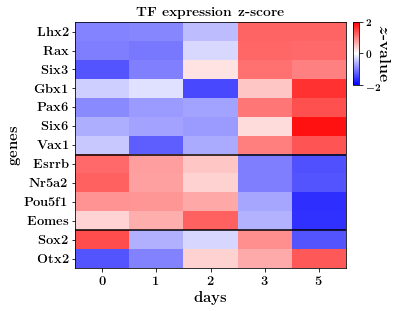

In [18]:
####################################
## make z-value plot (expressino) ##
####################################

## heatmap according to lag ##
days_list = [0,1,2,3,5]
plt_xticks = [r'\bf '+str(day) for day in days_list]

aspect_ratio = 0.35

## selection & sorting criteria ##
corr_thr = 0.5
bool_select1 = (plt_df['best_corr_ef'] >  corr_thr) & (plt_df['lag_ef'].isin([0,-1]))
sort_idx1 = plt_df[bool_select1].sort_values(['bool-ef-up','bool-ef-down',
                                            'expr_argmax', 'footprint_ef_argmax', 'gene_names'],
                                           ascending=[False,False,True,True,True]).index.tolist()

n_efup_plt_tfs   = len(set(plt_df['gene_names'][bool_select1][plt_df['bool-ef-up'][bool_select1]]))
n_efdown_plt_tfs = len(set(plt_df['gene_names'][bool_select1][plt_df['bool-ef-down'][bool_select1]]))
## selection & sorting criteria ##

## plot labels ##
motif_names_plt_pre = [motif.replace('_','-') for motif in np.array(motif_names)[sort_idx1] ]
motif_names_plt = []
for motif in motif_names_plt_pre:
    
    if len(motif.split('-')) == 2:
        motif_names_plt.append(motif.split('-')[0])
    elif len(motif.split('-')) > 2:
        motif_names_plt.append('-'.join(motif.split('-')[:2]))
print(motif_names_plt)
motif_names_plt = list(np.array(motif_names_plt))
motif_names_plt = [r'\bf '+motif for motif in motif_names_plt] 
gene_names_plt  = list(np.array(gene_names)[sort_idx1])
gene_names_plt  = [r'\bf '+gene for gene in gene_names_plt] 
## plot labels ##

## distill so that duplicates not plotted ##
tmp_list = list(np.array(gene_names)[sort_idx1])
tmp_list_set = set()
gene_set = [x for x in tmp_list if not (x in tmp_list_set or tmp_list_set.add(x))]
tmp_list_set = set()
gene_set_idx = [tmp_list.index(x) for x in tmp_list if not (x in tmp_list_set or tmp_list_set.add(x))]
#print(gene_set, len(gene_set))
#print(gene_set_idx, len(gene_set_idx))
gene_set_plt  = [r'\bf '+gene for gene in gene_set]
## #########################################

fig = plt.figure(figsize=(5,13))

im = plt.imshow(de_tf_expr_zvals[sort_idx1][gene_set_idx],interpolation='nearest', 
                    vmin=-2.0, vmax=2.0, cmap='bwr',aspect=aspect_ratio)
plt.yticks(range(len(gene_set)),gene_set_plt,fontsize=13)
plt.title(r'\bf TF expression z-score',fontsize=14)
plt.ylabel(r'\bf genes',fontsize=15)


plt.xticks(range(len(days_list)),plt_xticks,fontsize=13)
plt.xlabel(r'\bf days',fontsize=15)
plt.axhline(n_efup_plt_tfs-0.5,ls='-',color='black')
plt.axhline(n_efdown_plt_tfs+n_efup_plt_tfs-0.5,ls='-',color='black')

## add color bar ##
ax = plt.gca()
cbar_height = ax.get_position().height * 0.25
cax = fig.add_axes([ax.get_position().x1+.09,
                    ax.get_position().y1-0.074,0.016,
                    cbar_height])
cbar = fig.colorbar(im, cax=cax, orientation='vertical',ticklocation='right') 
cbar.set_label(r'\bf $z$-value', fontsize=16, labelpad=10, rotation=270)
## add color bars ##

plt.tight_layout()
#file_str = '05_organoids_tobias_footprint_expression-positive-correlations-'+vals_plt+'.pdf'
#print(file_str)
#plt.savefig('./figures_paper/'+file_str,bbox_inches='tight')
plt.show()

/home/andrew/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


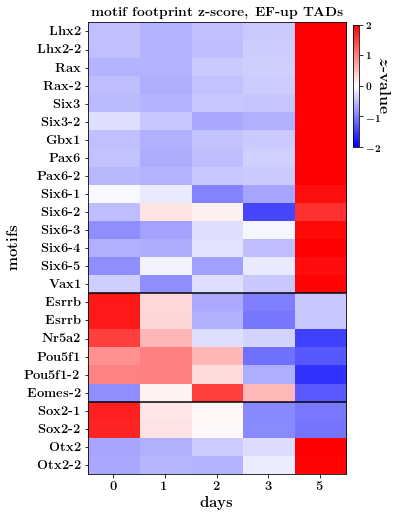

In [19]:
################################
## make z-value plot (motifs) ##
################################

vals_plt = 'EFup'
#vals_plt = 'genome-wide'

## heatmap according to lag ##
days_list = [0,1,2,3,5]
plt_xticks = [r'\bf '+str(day) for day in days_list]

aspect_ratio = 0.35

## selection & sorting criteria ##
corr_thr = 0.5
bool_select1 = (plt_df['best_corr_ef'] >  corr_thr) & (plt_df['lag_ef'].isin([0,-1]))
sort_idx1 = plt_df[bool_select1].sort_values(['bool-ef-up','bool-ef-down',
                                            'expr_argmax', 'footprint_ef_argmax', 'gene_names'],
                                           ascending=[False,False,True,True,True]).index.tolist()

n_efup_plt_tfs   = plt_df['bool-ef-up'][bool_select1].sum()
n_efdown_plt_tfs = plt_df['bool-ef-down'][bool_select1].sum()
## selection & sorting criteria ##

## plot labels ##
motif_names_plt_pre = [motif.replace('_','-') for motif in np.array(motif_names)[sort_idx1] ]
motif_names_plt = []
for motif in motif_names_plt_pre:
    
    if len(motif.split('-')) == 2:
        motif_names_plt.append(motif.split('-')[0])
    elif len(motif.split('-')) > 2:
        motif_names_plt.append('-'.join(motif.split('-')[:2]))
#print(motif_names_plt)
motif_names_plt = list(np.array(motif_names_plt))
motif_names_plt = [r'\bf '+motif for motif in motif_names_plt] 
gene_names_plt  = list(np.array(gene_names)[sort_idx1])
gene_names_plt  = [r'\bf '+gene for gene in gene_names_plt] 
## plot labels ##

fig = plt.figure(figsize=(5,13))

if vals_plt == 'expr':
    im = plt.imshow(de_tf_expr_zvals[sort_idx1],interpolation='nearest', 
                    vmin=-2.0, vmax=2.0, cmap='bwr',aspect=aspect_ratio)
    plt.yticks(range(len(motif_names_plt)),gene_names_plt,fontsize=13)
    plt.title(r'\bf TF expression z-score',fontsize=14)
    plt.ylabel(r'\bf genes',fontsize=15)
    
elif vals_plt == 'EFup':
    im = plt.imshow(de_motif_footprint_ef_zvals[sort_idx1],interpolation='nearest', 
                    vmin=-2.0, vmax=2.0, cmap='bwr',aspect=aspect_ratio)
    plt.yticks(range(len(motif_names_plt)),motif_names_plt,fontsize=13)
    plt.title(r'\bf motif footprint z-score, EF-up TADs',fontsize=14)
    plt.ylabel(r'\bf motifs',fontsize=15)

    
elif vals_plt == 'genome-wide':
    im = plt.imshow(de_motif_footprint_zvals[sort_idx1],interpolation='nearest', 
                    vmin=-2.0, vmax=2.0, cmap='bwr',aspect=aspect_ratio)
    plt.yticks(range(len(motif_names_plt)),motif_names_plt,fontsize=13)
    plt.title(r'\bf motif footprint z-score, genome-wide',fontsize=14)
    plt.ylabel(r'\bf motifs',fontsize=15)


plt.xticks(range(len(days_list)),plt_xticks,fontsize=13)
plt.xlabel(r'\bf days',fontsize=15)
plt.axhline(n_efup_plt_tfs-0.5,ls='-',color='black')
plt.axhline(n_efdown_plt_tfs+n_efup_plt_tfs-0.5,ls='-',color='black')

## add color bar ##
ax = plt.gca()
cbar_height = ax.get_position().height * 0.25
cax = fig.add_axes([ax.get_position().x1+.09,
                    ax.get_position().y1-0.155,0.016,
                    cbar_height])
cbar = fig.colorbar(im, cax=cax, orientation='vertical',ticklocation='right') 
cbar.set_label(r'\bf $z$-value', fontsize=16, labelpad=10, rotation=270)
## add color bars ##

plt.tight_layout()
#file_str = '05_organoids_tobias_footprint_expression-positive-correlations-'+vals_plt+'.pdf'
#print(file_str)
#plt.savefig('./figures_paper/'+file_str,bbox_inches='tight')
plt.show()